## This notebook explores the path model for jerk signatures. 
### It shows how to read in the datafiles from https://morpho.ipgp.fr/4DEarth/ and produce basic figures.

In [2]:
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
sys.path.append( os.path.abspath('..') ) #This line needs to point to whereever the jerks module has been compiled.
from jerks import jerks

In [3]:
# Download the spherical harmonic time-series output from the path model
import os.path
if not os.path.exists('Gauss_Bsurf.mat'): 
    !wget http://morpho.ipgp.fr/4DEarth/Gauss_Bsurf.mat

In [4]:
# import the (Matlab formatted) dataset
import h5py
filepath = 'Gauss_Bsurf.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

In [5]:
coeffs = arrays['gnm'][:,:].T
time = arrays['timers'].flatten()
print( 'Shape of gmn array: ', arrays['gnm'].shape )
print ('Times (in years) of output', time )

Shape of gmn array:  (960, 50001)
Times (in years) of output [ 4200.   4200.2  4200.4 ... 14199.6 14199.8 14200. ]


In [6]:
# jerk times as defined in catalogue
jerk_times = [4600,5750,2920, 1915, 6490,7300,7620,7840,8880,9673,10590,12620,13411,13546]

#### Plot a picture of Br at the CMB at the time of jerk 9 (Python index 8, t=8880) to check that everything works

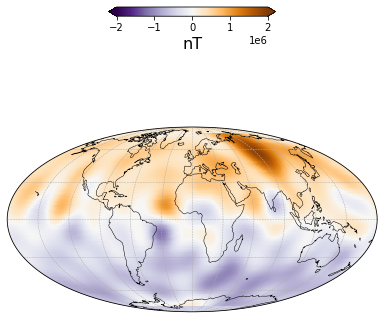

In [7]:
import chaosmagpy as cp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec

index = np.argmin(abs(time-jerk_times[8]))

coeffs_single_epoch = arrays['gnm'][:,index]

radius = 3485.

theta = np.linspace(1., 179., 181)
phi = np.linspace(-180., 180, 361)
Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs_single_epoch, radius, theta, phi, grid=True,nmax=13)

limit = 2e6  # nT colorbar limit

# create figure
fig = plt.figure(figsize=(16, 10))

# make array of axes
axes = []
gs = fig.add_gridspec(3,3)
axes.append(plt.subplot(gs[1, :], projection=ccrs.Mollweide()))

for ax in axes:
    pc = ax.pcolormesh(phi, 90. - theta, Br, cmap='PuOr_r', vmin=-limit,
                       vmax=limit, transform=ccrs.PlateCarree())
    ax.gridlines(linewidth=0.5, linestyle='dashed',
                 ylocs=np.linspace(-90, 90, num=7),  # parallels
                 xlocs=np.linspace(-180, 180, num=13))  # meridians
    ax.coastlines(linewidth=0.5)

# inset axes into global map and move upwards
cax = inset_axes(axes[-1], width="45%", height="5%", loc='upper center',
                 borderpad=-12)

# use last artist for the colorbar
clb = plt.colorbar(pc, cax=cax, extend='both', orientation='horizontal')
clb.set_label('nT', fontsize=16)

plt.subplots_adjust(top=0.785, bottom=0.015, left=0.008,
                    right=0.992, hspace=0.0, wspace=0.0)

# Analysis of jerk 9

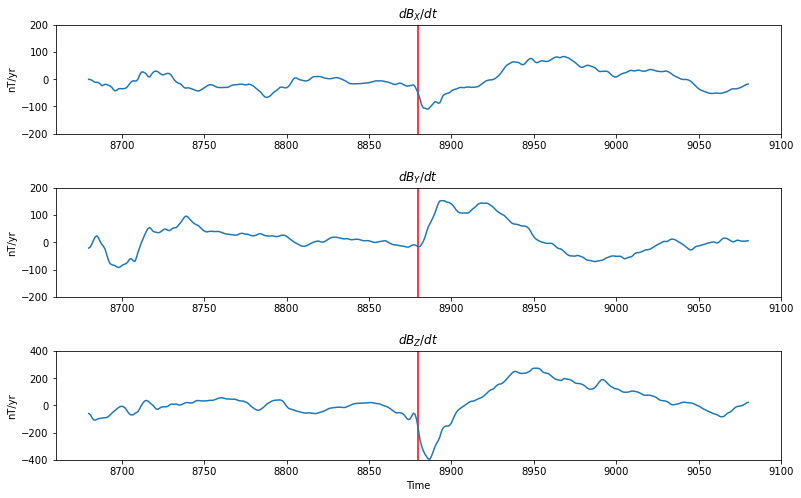

In [8]:
# plot SV series at theta = 90, phi = 45
radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


a = 200
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(13,8) )
ax1.vlines(jerk_times[jerk_number],-a,a,'r')
ax1.plot( time_yearly,Bx_dot )
ax1.set_ylim(-a,a)
ax1.set_ylabel('nT/yr')
ax1.set_title(r'$d{B_X}/dt$')
a=200
ax2.vlines(jerk_times[jerk_number],-a,a,'r')
ax2.plot( time_yearly,By_dot )
#ax2.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax2.set_ylim(-200,200)
ax2.set_ylabel('nT/yr')
ax2.set_title(r'$d{B_Y}/dt$')
a=400
ax3.vlines(jerk_times[jerk_number],-a,a,'r')
ax3.plot( time_yearly,Bz_dot )
#ax3.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax3.set_ylim(-400,400)
ax3.set_xlabel('Time')
ax3.set_ylabel('nT/yr')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig('Jerk9_SV_timeseries.pdf')

#### Run jerk finder on using a 10/20% relative error on 400 year interval (400 data).

In [9]:
run_components=[0,1,2] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
CP_NBINS = 1*np.int(TIMES_MAX - TIMES_MIN) #one per year
CP_hist_save = np.zeros( (len(run_components),CP_NBINS), dtype=int )
    
for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    K_MIN = 0
    K_MAX = 100
    sigmas = np.array([10,5,10],dtype = float)
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    # sigma_change_value = sigmas(1)
    # sigma_move = sigmas(2)
    # sigma_birth = sigmas(3)

    THIN = 100
    NBINS = 100
    credible = 0.0
    RUNNING_MODE = 1
    burn_in = 10000
    NSAMPLE = 2000000+burn_in
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    CP_hist_run = np.zeros( CP_NBINS, dtype=int )
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP_hist_run, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, cp_nbins = CP_NBINS,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    CP_hist_save[i,:] = CP_hist_run[:]
    print(i, Acceptance_rates)
    

/var/folders/dt/wd97pc0d21j7n7dqqg7xy7bc0000gp/T/ipykernel_85637/1510916175.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  CP_NBINS = 1*np.int(TIMES_MAX - TIMES_MIN) #one per year


TypeError: jerks.jerks.rjmcmc() missing required argument 'time_intervals_edges' (pos 14)

<Figure size 432x288 with 0 Axes>

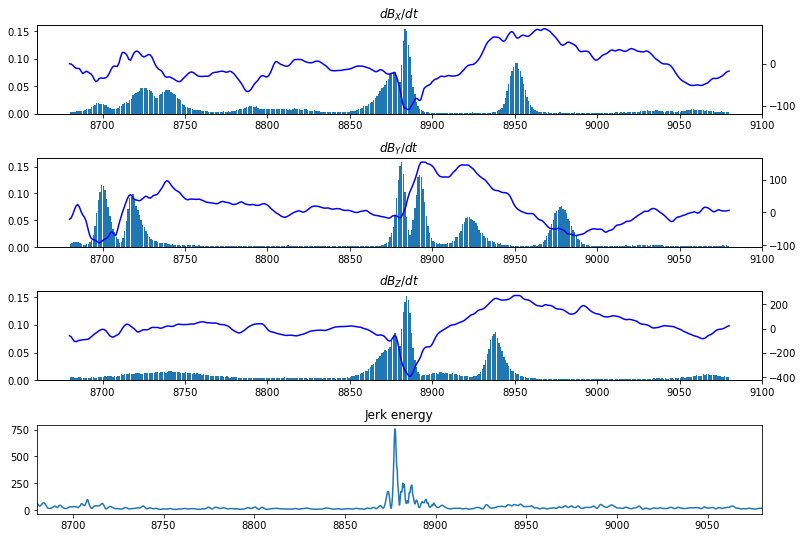

In [22]:
plt.figure()
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,9) )
fac = (NSAMPLE-burn_in)/THIN
left_edges = np.linspace(TIMES_MIN, TIMES_MAX, CP_NBINS,endpoint=False)
ax1.bar(left_edges, CP_hist_save[0,:]/fac, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
ax2.bar(left_edges, CP_hist_save[1,:]/fac, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
ax3.bar(left_edges, CP_hist_save[2,:]/fac, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
ax5 = ax1.twinx()
ax5.plot(TIMES,Bx_dot,'b')
ax5 = ax2.twinx()
ax5.plot(TIMES,By_dot,'b')
ax5 = ax3.twinx()
ax5.plot(TIMES,Bz_dot,'b')

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4.plot(time_EJ, EJ )
ax4.set_xlim(time_yearly.min(), time_yearly.max() )
ax4.set_title('Jerk energy')

ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


<Figure size 432x288 with 0 Axes>

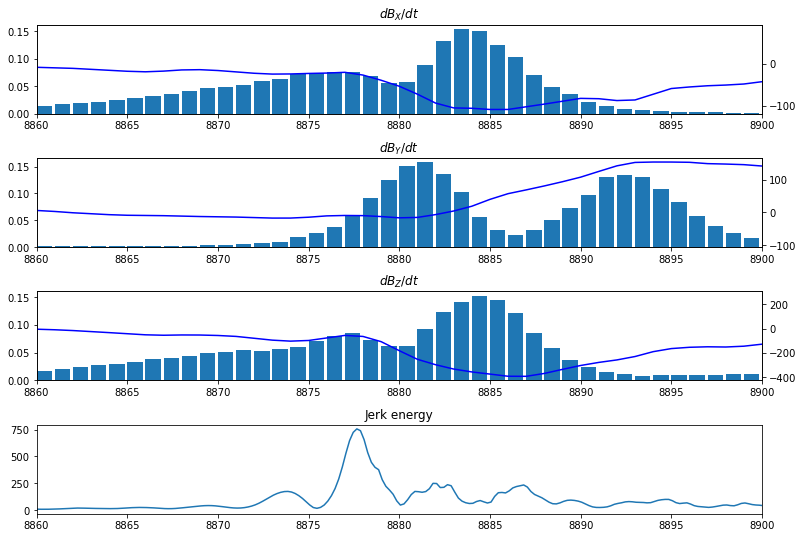

In [23]:
plt.figure()
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,9) )
fac = (NSAMPLE-burn_in)/THIN
left_edges = np.linspace(TIMES_MIN, TIMES_MAX, CP_NBINS,endpoint=False)
ax1.bar(left_edges, CP_hist_save[0,:]/fac, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
ax2.bar(left_edges, CP_hist_save[1,:]/fac, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
ax3.bar(left_edges, CP_hist_save[2,:]/fac, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
ax5 = ax1.twinx()
ax5.plot(TIMES,Bx_dot,'b')
ax5 = ax2.twinx()
ax5.plot(TIMES,By_dot,'b')
ax5 = ax3.twinx()
ax5.plot(TIMES,Bz_dot,'b')
ax1.set_xlim(8860, 8900 )
ax2.set_xlim(8860, 8900 )
ax3.set_xlim(8860, 8900 )

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4.plot(time_EJ, EJ )
ax4.set_xlim(8860, 8900 )
ax4.set_title('Jerk energy')

ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'zoomed.pdf')


In [10]:
from scipy.signal import find_peaks
for i in range(3):
    peaks,_ = find_peaks( CP_hist_save[i,:]/fac, height = 0.1, distance = 10)
    for j in peaks:
        print( 'Jerks found in component {0:d} at times {1:f}'.format(i,left_edges[j] ))

Jerks found in component 0 at times 8883.000000
Jerks found in component 1 at times 8699.000000
Jerks found in component 1 at times 8881.000000
Jerks found in component 1 at times 8892.000000
Jerks found in component 2 at times 8884.000000


In [ ]:
# Run the model on a lat/long grid over the 400 years spanning jerk 9
# Assume 10% error
# Collect all the histograms into a list and save to disk - this takes a while...

if not os.path.exists('Jerk9_lat_long.results'): 
        # calculate


    results = []
    run_components=[0,1,2]
    SV_error = 10
    discretise_size = 100
    TIMES = time_yearly
    TIMES_MIN = TIMES.min()
    TIMES_MAX = TIMES.max()
    NUM_DATA = len(TIMES)

    CP_NBINS = 1*np.int(TIMES_MAX - TIMES_MIN) #one per year
    CP_hist_save = np.zeros( (len(run_components),CP_NBINS), dtype=int )

    radius = 6371.
    phis = np.linspace(-180,160 ,18)
    thetas = np.linspace(-80,80,9)+90

    
    done = 0

    for theta_i in range(len(thetas)):
        for phi_i in range(len(phis)):
            
            Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, thetas[theta_i], phis[phi_i],nmax=13)
            Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
            Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)
            
            for i in run_components:
                if i == 0:
                    SV = Bx_dot
                elif i == 1:
                    SV = By_dot
                else:
                    SV = Bz_dot

                delta_SV = 0.01 * SV_error * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
                Y_MIN = -400
                Y_MAX = 400

                K_MIN = 0
                K_MAX = 100
                sigmas = np.array([10,5,10],dtype = float)
                TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
                # sigma_change_value = sigmas(1)
                # sigma_move = sigmas(2)
                # sigma_birth = sigmas(3)

                THIN = 100
                NBINS = 100
                credible = 0.0
                build_marginal_intensity = True
                RUNNING_MODE = 1
                burn_in = 10000
                NSAMPLE = 2000000+burn_in
                Acceptance_rates=np.zeros(4)
                AV = np.zeros(discretise_size,dtype=float)
                SUP = np.zeros(discretise_size,dtype=float)
                INF = np.zeros(discretise_size,dtype=float)
                MEDIAN = np.zeros(discretise_size,dtype=float)
                MODE = np.zeros(discretise_size,dtype=float)
                CP_hist_run = np.zeros( CP_NBINS, dtype=int )
                MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
                N_CP_hist = np.zeros( K_MAX, dtype=int)

                (Acceptance_rates,SUP, INF, AV, MEDIAN, MODE, CP_hist_run, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
                 sigmas=sigmas, burn_in=burn_in, 
                 nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
                 y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
                 k_max=K_MAX, discretise_size=discretise_size, cp_nbins = CP_NBINS,
                 thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)

                # save the model
                fac = (NSAMPLE-burn_in)/THIN
                results.append([thetas[theta_i], phis[phi_i],i,CP_hist_run[:]/fac ])
        #CP_hist_save[i,:] = CP_hist_run[:]
                if done % 10 == 0:
                    print('Done '+str(done)+' of '+str( len(thetas) * len(phis) * len(run_components) ) )
                done += 1

    import pickle
    with open("Jerk9_lat_long.results", "wb") as fp:   #Pickling
        pickle.dump(results, fp)



Done 0 of 486
Done 10 of 486
Done 20 of 486
Done 30 of 486
Done 40 of 486
Done 50 of 486
Done 60 of 486
Done 70 of 486
Done 80 of 486
Done 90 of 486
Done 100 of 486
Done 110 of 486
Done 120 of 486
Done 130 of 486
Done 140 of 486
Done 150 of 486
Done 160 of 486
Done 170 of 486
Done 180 of 486
Done 190 of 486
Done 200 of 486
Done 210 of 486
Done 220 of 486
Done 230 of 486
Done 240 of 486
Done 250 of 486
Done 260 of 486
Done 270 of 486
Done 280 of 486
Done 290 of 486
Done 300 of 486
Done 310 of 486
Done 320 of 486
Done 330 of 486
Done 340 of 486
Done 350 of 486
Done 360 of 486
Done 370 of 486
Done 380 of 486
Done 390 of 486
Done 400 of 486
Done 410 of 486
Done 420 of 486
Done 430 of 486
Done 440 of 486
Done 450 of 486
Done 460 of 486
Done 470 of 486
Done 480 of 486


In [29]:
import pickle
with open("Jerk9_lat_long.results", "rb") as fp:   # Unpickling
     results = pickle.load(fp)

3 jerks found at theta = 90.0 phi = 100.0 component = 2
Max jerk count is 4


<Figure size 432x288 with 0 Axes>

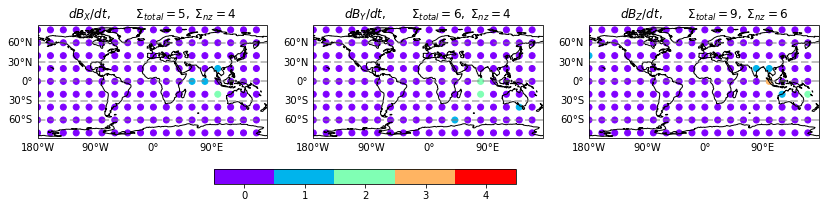

In [326]:
# make plot of number of jerks over 8880 +/- 30 years
from scipy.signal import find_peaks
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

height_threshold = 0.4
distance_threshold = 3

x_theta, x_phi,x_count = [],[],[]
y_theta, y_phi,y_count = [],[],[]
z_theta, z_phi,z_count = [],[],[]

for j in range(len(results)):
    theta = results[j][0]
    phi = results[j][1]
    component = results[j][2]
    CP = results[j][3]
    if component == 0:
        x_theta.append(theta); x_phi.append(phi)
        peaks,_ = find_peaks( CP, height = height_threshold, distance = distance_threshold)
        x_count.append(len( [time_yearly[i] for i in peaks if (time_yearly[i] < 8880+30 and time_yearly[i] > 8880-30)]))

    if component == 1:
        y_theta.append(theta); y_phi.append(phi)
        peaks,_ = find_peaks( CP, height = height_threshold, distance = distance_threshold)
        y_count.append(len( [time_yearly[i] for i in peaks if (time_yearly[i] < 8880+30 and time_yearly[i] > 8880-30)]))
    
    if component == 2:
        z_theta.append(theta); z_phi.append(phi)
        peaks,_ = find_peaks( CP, height = height_threshold, distance = distance_threshold)
        z_count.append(len( [time_yearly[i] for i in peaks if (time_yearly[i] < 8880+30 and time_yearly[i] > 8880-30)]))
    t = len( [time_yearly[i] for i in peaks 
                 if (time_yearly[i] < 8880+30 and time_yearly[i] > 8880-30)])
    if t >= 3:
                 print(str(t) + ' jerks found at theta = ' + str(theta) + ' phi = ' + str(phi) + ' component = ' + str(component))
max_count = 4#max(max(x_count),max(y_count),max(z_count))
# force this to be 4.

cmap = plt.get_cmap('rainbow', max_count-0+1)
print( 'Max jerk count is ' + str(max_count))   
plt.figure()
axes = [0,0,0]
f, (axes[0],axes[1],axes[2]) = plt.subplots(1, 3, figsize=(14,5),subplot_kw={'projection': ccrs.PlateCarree()}) 

for i in range(3):
    if i == 0:
        cax = axes[0].scatter(x_phi,90.-np.array(x_theta),c=x_count,cmap=cmap, vmin=0-0.5, vmax=(max_count)+0.5)
        axes[i].set_title(r'$dB_X/dt, \qquad \Sigma_{{total}} = {0:d},\; \Sigma_{{nz}} = {1:d}$'.format(sum(x_count),np.sum(np.array(x_count)>0)))
    elif i == 1:
        cax = axes[1].scatter(y_phi,90.-np.array(y_theta),c=y_count,cmap=cmap, vmin=0-0.5, vmax=(max_count)+0.5)
        axes[i].set_title(r'$dB_Y/dt, \qquad \Sigma_{{total}} = {0:d},\; \Sigma_{{nz}} = {1:d}$'.format(sum(y_count),np.sum(np.array(y_count)>0)))
    elif i == 2:
        cax = axes[2].scatter(z_phi,90.-np.array(z_theta),c=z_count,cmap=cmap, vmin=0-0.5, vmax=(max_count)+0.5)
        axes[i].set_title(r'$dB_Z/dt, \qquad \Sigma_{{total}} = {0:d},\; \Sigma_{{nz}} = {1:d}$'.format(sum(z_count),np.sum(np.array(z_count)>0)))
        
    axes[i].coastlines()
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=[1,0,0,1],
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

cb_ax = f.add_axes([0.30, 0.2, 0.3, 0.4])
#cb_ax.scatter([0,1,2,3],[0,1,2,3],[0,1,2,4])
cbar = f.colorbar(cax, ax=cb_ax, orientation = 'horizontal')
cb_ax.set_axis_off()

cbar.set_ticks(range(0,max_count+1))
f.savefig('Jerk9_' + str(int(10*height_threshold)) + '_' + str(distance_threshold) + '.pdf',bbox_inches = 'tight')


In [310]:
np.sum(np.array([3,4,0]) > 0)

2

<Figure size 432x288 with 0 Axes>

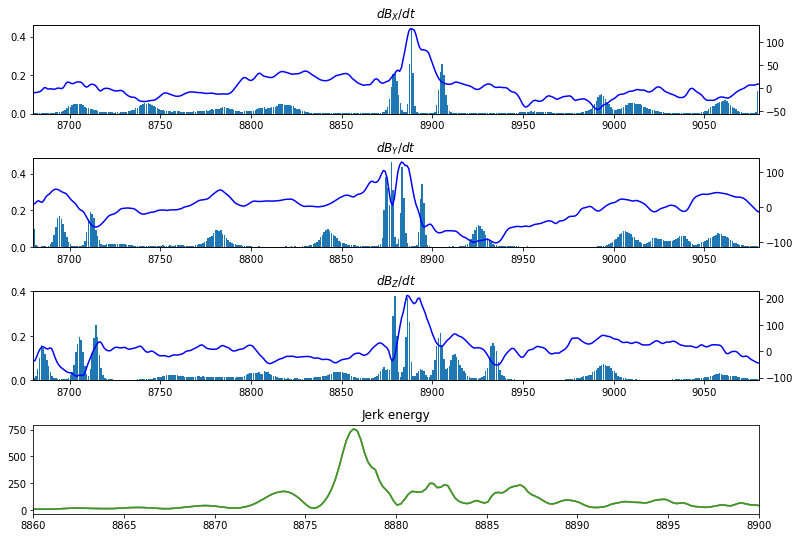

In [266]:
jerk_number = 8 # in Python indexing
# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)


plt.figure()
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,9) )

for j in range(len(results)):
    theta = results[j][0]
    phi = results[j][1]
    component = results[j][2]
    CP = results[j][3]
    if(theta==90 and phi == 80):
        theta=90
        phi=80
        Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
        Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
        Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)
        left_edges = np.linspace(TIMES_MIN, TIMES_MAX, CP_NBINS,endpoint=False)
        if component == 0:
            ax1.bar(left_edges, CP, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
            ax1.set_xlim(time_yearly.min(), time_yearly.max() )
            ax5 = ax1.twinx()
            ax5.plot(TIMES,Bx_dot,'b')
            ax1.set_title(r'$d{B_X}/dt$')

        if component == 1:
            ax2.bar(left_edges, CP, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
            ax2.set_xlim(time_yearly.min(), time_yearly.max() )
            ax5 = ax2.twinx()
            ax5.plot(TIMES,By_dot,'b')
            ax2.set_title(r'$d{B_Y}/dt$')
            
        if component == 2:
            ax3.bar(left_edges, CP, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
            ax3.set_xlim(time_yearly.min(), time_yearly.max() )
            ax5 = ax3.twinx()
            ax5.plot(TIMES,Bz_dot,'b')
            ax3.set_title(r'$d{B_Z}/dt$')
            
        time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
        ax4.plot(time_EJ, EJ )
        ax4.set_xlim(8860, 8900 )
        ax4.set_title('Jerk energy')

        
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)


0 [48.4129982  42.63526154  3.75784326  3.76214623]
1 [52.38130188 43.15407944  4.47579908  4.48218584]
2 [75.77729797 48.92283249  6.15102911  6.15856504]


<Figure size 432x288 with 0 Axes>

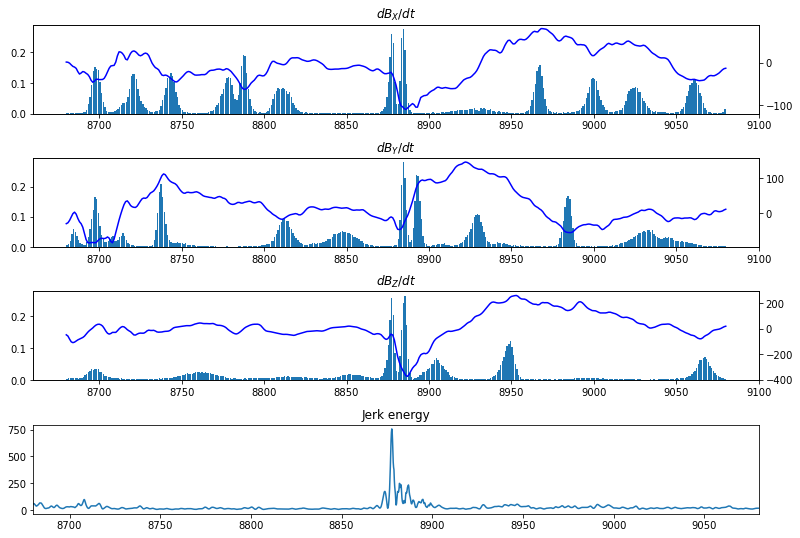

In [39]:
# test
radius = 6371.
theta = 90
phi = 40
jerk_number = 8 # in Python indexing

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


run_components=[0,1,2] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
CP_NBINS = 1*np.int(TIMES_MAX - TIMES_MIN) #one per year
CP_hist_save = np.zeros( (len(run_components),CP_NBINS), dtype=int )
    
for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    K_MIN = 0
    K_MAX = 100
    sigmas = np.array([10,5,10],dtype = float)
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    # sigma_change_value = sigmas(1)
    # sigma_move = sigmas(2)
    # sigma_birth = sigmas(3)

    THIN = 100
    NBINS = 100
    credible = 0.0
    RUNNING_MODE = 1
    burn_in = 10000
    NSAMPLE = 2000000+burn_in
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    CP_hist_run = np.zeros( CP_NBINS, dtype=int )
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP_hist_run, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, cp_nbins = CP_NBINS,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    CP_hist_save[i,:] = CP_hist_run[:]
    print(i, Acceptance_rates)
    
plt.figure()
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,9) )
fac = (NSAMPLE-burn_in)/THIN
left_edges = np.linspace(TIMES_MIN, TIMES_MAX, CP_NBINS,endpoint=False)
ax1.bar(left_edges, CP_hist_save[0,:]/fac, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
ax2.bar(left_edges, CP_hist_save[1,:]/fac, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
ax3.bar(left_edges, CP_hist_save[2,:]/fac, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
ax5 = ax1.twinx()
ax5.plot(TIMES,Bx_dot,'b')
ax5 = ax2.twinx()
ax5.plot(TIMES,By_dot,'b')
ax5 = ax3.twinx()
ax5.plot(TIMES,Bz_dot,'b')

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4.plot(time_EJ, EJ )
ax4.set_xlim(time_yearly.min(), time_yearly.max() )
ax4.set_title('Jerk energy')

ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

In [ ]:
# Make movie of jerk occurences
if not os.path.exists('movies'):
    os.mkdir('movies')
for t_index in range(len(left_edges)):
    #plt.figure()
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()} )
    #ax1 = plt.axes(projection=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_global()
    #ax2 = plt.axes(projection=ccrs.PlateCarree())
    ax2.coastlines()
    ax2.set_global()
    #ax3 = plt.axes(projection=ccrs.PlateCarree())
    ax3.coastlines()
    ax3.set_global()
    for j in range(len(results)):
        theta = results[j][0]
        phi = results[j][1]
        component = results[j][2]
        CP = results[j][3]
        if component == 0:
            ax1.plot(phi, theta-90, 'bo', markersize=CP[t_index]*50 )
        elif component == 1:
            ax2.plot(phi, theta-90, 'bo', markersize=CP[t_index]*50 )
        else:
            ax3.plot(phi, theta-90, 'bo', markersize=CP[t_index]*50 )
        ax1.set_title('Time '+str(left_edges[t_index]),fontsize=20)
    plt.savefig('movies/Jerk9_time_index_'+'{:03}'.format(t_index)+'.png',bbox_inches='tight',pad_inches=0.7,dpi=400)
    plt.close()
    
    

In [ ]:
# Find quasi-global-integrated activity as a function of time by forming sum of histograms weighted by sin(theta)
plt.figure (figsize = (18,10))
activity = np.zeros(len(left_edges))
temp = np.zeros((len(left_edges),3))
for t_index in range(len(left_edges)):
    for j in range(len(results)):
        component = results[j][2]
        CP = results[j][3]
        theta = results[j][0]
        temp[t_index,component] += np.sin(theta*np.pi/180.0) * CP[t_index]
plt.figure()
plt.plot(left_edges, temp[:,0],'r', label=r'$B_X$')
plt.plot(left_edges, temp[:,1],'b', label=r'$B_Y$')
plt.plot(left_edges, temp[:,2],'g',label=r'$B_Z$')
plt.legend()
plt.savefig( 'Jerk9_activity.png',bbox_inches='tight',pad_inches=0.7,dpi=400)

## Intensity?

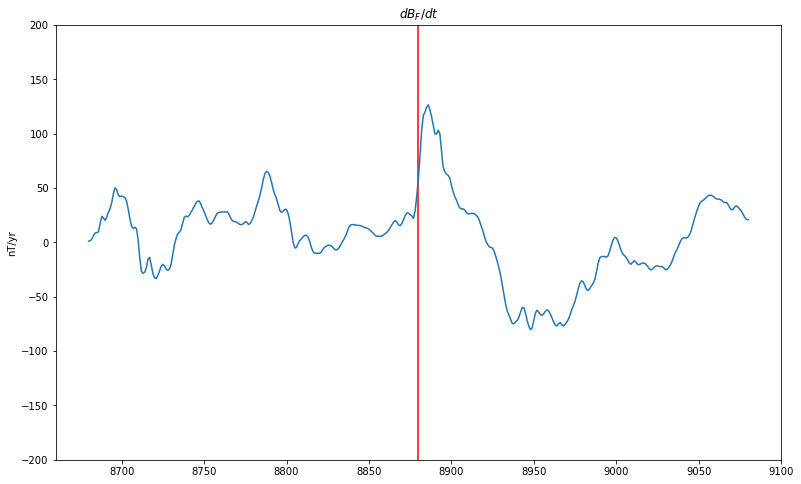

In [20]:
# plot SV series at theta = 90, phi = 45
radius = 6371.
theta = 90
phi = 45
jerk_number = 8

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
BF_yearly = np.sqrt(Btheta_yearly**2+Br_yearly**2 + Bphi_yearly**2)
BF_dot = np.gradient(BF_yearly,time_yearly)


a = 200
fig, ax1 = plt.subplots(1, 1, figsize=(13,8) )
ax1.vlines(jerk_times[jerk_number],-a,a,'r')
ax1.plot( time_yearly,BF_dot )
ax1.set_ylim(-a,a)
ax1.set_ylabel('nT/yr')
ax1.set_title(r'$d{B_F}/dt$')
plt.savefig('Jerk9_SV_F_timeseries.pdf')



## Jerk 6

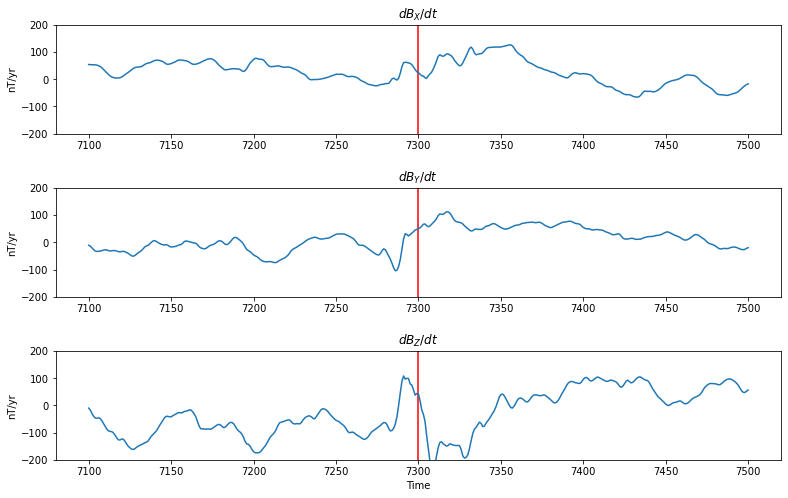

In [12]:
# plot SV series at theta = 90, phi = 45
radius = 6371.
theta = 90
phi = 45

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)

jerk_number = 5  #in Python indexing
# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


a = 200
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(13,8) )
ax1.vlines(jerk_times[jerk_number],-a,a,'r')
ax1.plot( time_yearly,Bx_dot )
ax1.set_ylim(-a,a)
ax1.set_ylabel('nT/yr')
ax1.set_title(r'$d{B_X}/dt$')

ax2.vlines(jerk_times[jerk_number],-a,a,'r')
ax2.plot( time_yearly,By_dot )
#ax2.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax2.set_ylim(-200,200)
ax2.set_ylabel('nT/yr')
ax2.set_title(r'$d{B_Y}/dt$')

ax3.vlines(jerk_times[jerk_number],-a,a,'r')
ax3.plot( time_yearly,Bz_dot )
#ax3.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax3.set_ylim(-200,200)
ax3.set_xlabel('Time')
ax3.set_ylabel('nT/yr')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig('Jerk6_SV_timeseries.pdf')

0 [52.82720184 40.72676468  4.46016502  4.46713448]
1 [50.29700089 42.50160217  3.88922787  3.89369178]
2 [71.22129822 39.75834274  5.89547539  5.90239716]


<Figure size 432x288 with 0 Axes>

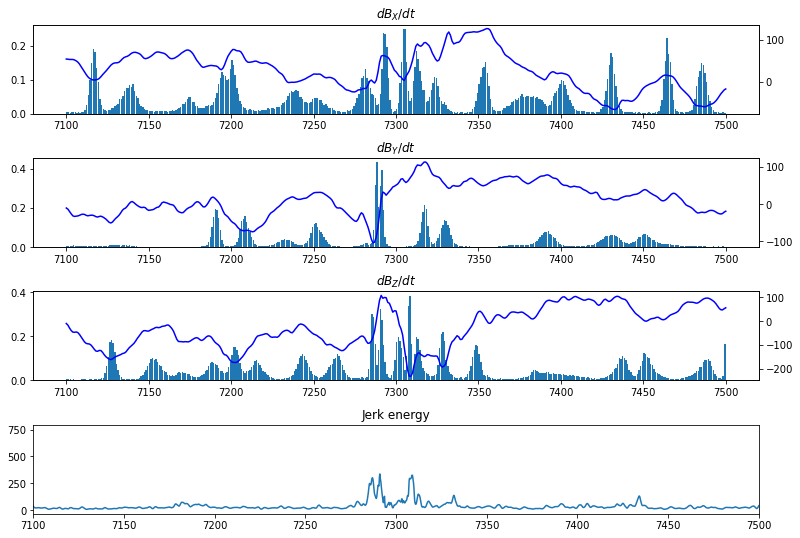

In [13]:
# compute histograms for a single location assuming 10% error budget 

run_components=[0,1,2] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
CP_NBINS = 1*np.int(TIMES_MAX - TIMES_MIN) #one per year
CP_hist_save = np.zeros( (len(run_components),CP_NBINS), dtype=int )
    
for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    K_MIN = 0
    K_MAX = 100
    sigmas = np.array([10,5,10],dtype = float)
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    # sigma_change_value = sigmas(1)
    # sigma_move = sigmas(2)
    # sigma_birth = sigmas(3)

    THIN = 100
    NBINS = 100
    credible = 0.0
    RUNNING_MODE = 1
    burn_in = 10000
    NSAMPLE = 2000000+burn_in
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    CP_hist_run = np.zeros( CP_NBINS, dtype=int )
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)

    (Acceptance_rates, SUP,  INF, AV, MEDIAN, MODE, CP_hist_run, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, cp_nbins = CP_NBINS,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    CP_hist_save[i,:] = CP_hist_run[:]
    print(i, Acceptance_rates)
    
    
plt.figure()
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,9) )
fac = (NSAMPLE-burn_in)/THIN
left_edges = np.linspace(TIMES_MIN, TIMES_MAX, CP_NBINS,endpoint=False)
ax1.bar(left_edges, CP_hist_save[0,:]/fac, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
ax2.bar(left_edges, CP_hist_save[1,:]/fac, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
ax3.bar(left_edges, CP_hist_save[2,:]/fac, align='edge', width = 0.85*(left_edges[1] - left_edges[0]))
ax5 = ax1.twinx()
ax5.plot(TIMES,Bx_dot,'b')
ax5 = ax2.twinx()
ax5.plot(TIMES,By_dot,'b')
ax5 = ax3.twinx()
ax5.plot(TIMES,Bz_dot,'b')

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4.plot(time_EJ, EJ )
ax4.set_xlim(time_yearly.min(), time_yearly.max() )
ax4.set_title('Jerk energy')

ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig('Jerk6_xyz_like_'+str(SV_error)+'.pdf')


In [ ]:
# Run the model on a lat/long grid over the 400 years spanning jerk 6
# collect all the histograms into a list and save to disk

# Run the model on a lat/long grid over the 400 years spanning jerk 9
# Assume 10% error
# Collect all the histograms into a list and save to disk

if not os.path.exists('Jerk6_lat_long.results'): 
        # calculate

    results = []
    run_components=[0,1,2]
    SV_error = 10
    discretise_size = 100
    TIMES = time_yearly
    TIMES_MIN = TIMES.min()
    TIMES_MAX = TIMES.max()
    NUM_DATA = len(TIMES)

    CP_NBINS = 1*np.int(TIMES_MAX - TIMES_MIN) #one per year
    CP_hist_save = np.zeros( (len(run_components),CP_NBINS), dtype=int )

    radius = 6371.
    phis = np.linspace(-180,160 ,18)
    thetas = np.linspace(-80,80,9)+90

    
    done = 0

    for theta_i in range(len(thetas)):
        for phi_i in range(len(phis)):
            
            Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, thetas[theta_i], phis[phi_i],nmax=13)
            Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
            Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)
            
            for i in run_components:
                if i == 0:
                    SV = Bx_dot
                elif i == 1:
                    SV = By_dot
                else:
                    SV = Bz_dot

                delta_SV = 0.01 * SV_error * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
                Y_MIN = -400
                Y_MAX = 400

                K_MIN = 0
                K_MAX = 100
                sigmas = np.array([10,5,10],dtype = float)
                TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
                # sigma_change_value = sigmas(1)
                # sigma_move = sigmas(2)
                # sigma_birth = sigmas(3)

                THIN = 100
                NBINS = 100
                credible = 0.0
                build_marginal_intensity = True
                RUNNING_MODE = 1
                burn_in = 10000
                NSAMPLE = 2000000+burn_in
                Acceptance_rates=np.zeros(4)
                AV = np.zeros(discretise_size,dtype=float)
                SUP = np.zeros(discretise_size,dtype=float)
                INF = np.zeros(discretise_size,dtype=float)
                MEDIAN = np.zeros(discretise_size,dtype=float)
                MODE = np.zeros(discretise_size,dtype=float)
                CP_hist_run = np.zeros( CP_NBINS, dtype=int )
                MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
                N_CP_hist = np.zeros( K_MAX, dtype=int)

                (Acceptance_rates,SUP, INF, AV, MEDIAN, MODE, CP_hist_run, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
                 sigmas=sigmas, burn_in=burn_in, 
                 nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
                 y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
                 k_max=K_MAX, discretise_size=discretise_size, cp_nbins = CP_NBINS,
                 thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)

                # save the model
                fac = (NSAMPLE-burn_in)/THIN
                results.append([thetas[theta_i], phis[phi_i],i,CP_hist_run[:]/fac ])
        #CP_hist_save[i,:] = CP_hist_run[:]
                if done % 10 == 0:
                    print('Done '+str(done)+' of '+str( len(thetas) * len(phis) * len(run_components) ) )
                done += 1



    import pickle
    with open("Jerk6_lat_long.results", "wb") as fp:   #Pickling
        pickle.dump(results, fp)



In [ ]:
import pickle
with open("Jerk6_lat_long.results", "rb") as fp:   # Unpickling
     results = pickle.load(fp)

In [ ]:
for t_index in range(len(left_edges)):
    #plt.figure()
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()} )
    #ax1 = plt.axes(projection=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_global()
    #ax2 = plt.axes(projection=ccrs.PlateCarree())
    ax2.coastlines()
    ax2.set_global()
    #ax3 = plt.axes(projection=ccrs.PlateCarree())
    ax3.coastlines()
    ax3.set_global()
    for j in range(len(results)):
        theta = results[j][0]
        phi = results[j][1]
        component = results[j][2]
        CP = results[j][3]
        if component == 0:
            ax1.plot(phi, theta-90, 'bo', markersize=CP[t_index]*50 )
        elif component == 1:
            ax2.plot(phi, theta-90, 'bo', markersize=CP[t_index]*50 )
        else:
            ax3.plot(phi, theta-90, 'bo', markersize=CP[t_index]*50 )
        ax1.set_title('Time '+str(left_edges[t_index]),fontsize=20)
    plt.savefig('movies/Jerk6_time_index_'+'{:03}'.format(t_index)+'.png',bbox_inches='tight',pad_inches=0.7,dpi=400)
    plt.close()
    

In [ ]:
# Find quasi-integrated activity by forming weighted sum of CP 
plt.figure (figsize = (18,10))
activity = np.zeros(len(left_edges))
temp = np.zeros((len(left_edges),3))
for t_index in range(len(left_edges)):
    for j in range(len(results)):
        component = results[j][2]
        CP = results[j][3]
        theta = results[j][0]
        temp[t_index,component] += np.sin(theta*np.pi/180.0) * CP[t_index]
plt.figure()
plt.plot(left_edges, temp[:,0],'r', label=r'$B_r$')
plt.plot(left_edges, temp[:,1],'b', label=r'$B_\theta$')
plt.plot(left_edges, temp[:,2],'g',label=r'$B_\phi$')
plt.legend()
plt.savefig( 'Jerk6_activity.png',bbox_inches='tight',pad_inches=0.7,dpi=400)

In [43]:
np.linspace(-180,160 ,18)

array([-180., -160., -140., -120., -100.,  -80.,  -60.,  -40.,  -20.,
          0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.])

7300


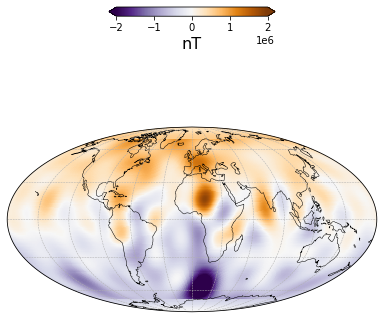

In [14]:
# plot of Br at time of jerk. 6
import chaosmagpy as cp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec

index = np.argmin(abs(time-jerk_times[5]))
print( jerk_times[5] )
coeffs_single_epoch = arrays['gnm'][:,index]

radius = 3485.

theta = np.linspace(1., 179., 181)
phi = np.linspace(-180., 180, 361)
Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs_single_epoch, radius, theta, phi, grid=True,nmax=13)

limit = 2e6  # nT colorbar limit

# create figure
fig = plt.figure(figsize=(16, 10))

# make array of axes
axes = []
gs = fig.add_gridspec(3,3)
axes.append(plt.subplot(gs[1, :], projection=ccrs.Mollweide()))

for ax in axes:
    pc = ax.pcolormesh(phi, 90. - theta, Br, cmap='PuOr_r', vmin=-limit,
                       vmax=limit, transform=ccrs.PlateCarree())
    ax.gridlines(linewidth=0.5, linestyle='dashed',
                 ylocs=np.linspace(-90, 90, num=7),  # parallels
                 xlocs=np.linspace(-180, 180, num=13))  # meridians
    ax.coastlines(linewidth=0.5)

# inset axes into global map and move upwards
cax = inset_axes(axes[-1], width="45%", height="5%", loc='upper center',
                 borderpad=-12)

# use last artist for the colorbar
clb = plt.colorbar(pc, cax=cax, extend='both', orientation='horizontal')
clb.set_label('nT', fontsize=16)

plt.subplots_adjust(top=0.785, bottom=0.015, left=0.008,
                    right=0.992, hspace=0.0, wspace=0.0)
plt.savefig('Jerk6_Br_CMB.pdf',bbox_inches='tight')

7300


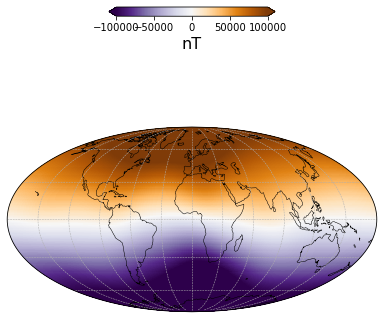

In [13]:
# plot of Br at time of jerk. 6
import chaosmagpy as cp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec

index = np.argmin(abs(time-jerk_times[5]))
print( jerk_times[5] )
coeffs_single_epoch = arrays['gnm'][:,index]

radius = 6381.

theta = np.linspace(1., 179., 181)
phi = np.linspace(-180., 180, 361)
Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs_single_epoch, radius, theta, phi, grid=True,nmax=13)

limit = 1e5  # nT colorbar limit

# create figure
fig = plt.figure(figsize=(16, 10))

# make array of axes
axes = []
gs = fig.add_gridspec(3,3)
axes.append(plt.subplot(gs[1, :], projection=ccrs.Mollweide()))

for ax in axes:
    pc = ax.pcolormesh(phi, 90. - theta, Br, cmap='PuOr_r', vmin=-limit,
                       vmax=limit, transform=ccrs.PlateCarree())
    ax.gridlines(linewidth=0.5, linestyle='dashed',
                 ylocs=np.linspace(-90, 90, num=7),  # parallels
                 xlocs=np.linspace(-180, 180, num=13))  # meridians
    ax.coastlines(linewidth=0.5)

# inset axes into global map and move upwards
cax = inset_axes(axes[-1], width="45%", height="5%", loc='upper center',
                 borderpad=-12)

# use last artist for the colorbar
clb = plt.colorbar(pc, cax=cax, extend='both', orientation='horizontal')
clb.set_label('nT', fontsize=16)

plt.subplots_adjust(top=0.785, bottom=0.015, left=0.008,
                    right=0.992, hspace=0.0, wspace=0.0)
plt.savefig('Jerk6_Br_ES.pdf',bbox_inches='tight')